In [426]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import matplotlib.colors as col
import numpy as np
import scipy as sp
import pandas as pd
import time

from bisect import bisect_left



In [457]:
class TrafficSimulation():
    
    def __init__(self,road_size,density):
        global cars, sorted_ids
        
        self.road_size = road_size
        self.density = density
        self.time_step = 0
        
        self.n_cars = round(self.road_size * self.density)
        self.road = -1*np.ones((2,road_size))
        
        self.initial_positions = np.random.choice(range(self.road_size),self.n_cars,replace=False)
            
        cars = [Car(id=i, position = np.array([1,initial_positions[i]]),vmax=5, p_slow = 0.25) for i in range(self.n_cars)]
        
        for car in cars:
            self.road[tuple(car.position)] = car.v
        
        self.cars_left = list(filter(lambda x : x.position[0] == 0, cars))
        self.cars_left = np.array([car.id for car in sorted(self.cars_left, key = lambda x : x.position[1])])
        
        self.cars_right = list(filter(lambda x : x.position[0] == 1, cars))
        self.cars_right = np.array([car.id for car in sorted(self.cars_right, key = lambda x : x.position[1])])        
        
        print('left: ',self.cars_left)
        print('right: ',self.cars_right)
        #self.sorted_ids = np.array([car.id for car in sorted(cars, key = lambda x : x.position)])
        
    def draw(self):
        
        
        C = np.array([[255,255,255],
            [235,198,83],
            [136,230,255],
            [0,200,255],
            [0,145,255],
            [0,92,205],
            [0,57,103]])
        
        cm = col.ListedColormap(C/255.0)
        
        self.fig, self.bars = plt.subplots(1, figsize=(15,7))
        self.bars.cla()
        im = self.bars.imshow(self.road,vmin = -1, vmax = 5, cmap = cm, interpolation='none')# plt.cm.binary)
        self.bars.axis('image')
        self.bars.get_yaxis().set_visible(False)
        self.bars.set_xticks(range(0,self.road.shape[1]+1,2))
        self.bars.set_title('t = ' + str(self.time_step)) 
        
        if self.time_step == 0:
            cbaxes = self.fig.add_axes([0, 0.7, 0.8, 0.02]) 
            cb = plt.colorbar(self.bars.imshow(self.road,vmin = -1, vmax = 5, cmap = cm)# plt.cm.binary)
            , cax = cbaxes, orientation = 'horizontal')  
        
        
        self.fig.subplots_adjust(left=0)


    def update_simulation(self):
        
        self.cars_left = list(filter(lambda x : x.position[0] == 0, cars))
        self.cars_left = np.array([car.id for car in sorted(self.cars_left, key = lambda x : x.position[1])])
        
        self.cars_right = list(filter(lambda x : x.position[0] == 1, cars))
        self.cars_right = np.array([car.id for car in sorted(self.cars_right, key = lambda x : x.position[1])])             
        #self.sorted_ids = np.array([car.id for car in sorted(cars, key = lambda x : x.position)])
        
        
        self.road.fill(-1)
        
        self.time_step += 1
        
        for car in cars:
            car.update_panorama()
            car.change_lane()
            car.update_v()
            car.update_position()

            self.road[tuple(car.position)] = car.v
        
        
        
        
        

class Car:
    
    def __init__(self, id, position, vmax, p_slow = 0.5):
        self.id = id
        self.position = position
        self.p_slow = p_slow
        
        self.back_car = -1
        
        self.front_car = -1
        
        self.v = 1
        self.vmax = vmax
        
        
    def update_panorama(self):
        
        if self.position[0] == 0: # car is on the left lane
            lane_rank = np.where(sim.cars_left == self.id)[0]
            self.front_car = sim.cars_left[(lane_rank+1) % len(sim.cars_left)][0]
            
            positions_other = [cars[i].position[1] for i in sim.cars_right] #check cars on the right
            lane_rank_other = bisect_left(positions_other, self.position[1])
            
            try:
                self.other_gap = sim.cars_right[lane_rank_other % len(sim.cars_right)] - self.position[1]
                self.back_gap = sim.cars_right[lane_rank_other-1 % len(sim.cars_right)] - self.position[1]
            except: # no cars in the other lane
                self.other_gap = sim.road_size - 1
                self.back_gap = sim.road_size - 1
            
            
            
            
            
            
        if self.position[0] == 1: # car is on the right lane
            lane_rank = np.where(sim.cars_right == self.id)[0]
                        
            self.front_car = sim.cars_right[(lane_rank+1) % len(sim.cars_right)][0]
            self.back_car = sim.cars_right[(lane_rank-1) % len(sim.cars_right)][0]
            
            positions_other = [cars[i].position[1] for i in sim.cars_left] #check cars on the left
            lane_rank_other = bisect_left(positions_other, self.position[1])
            try:
                self.other_gap = sim.cars_left[lane_rank_other % len(sim.cars_left)] - self.position[1]
                self.back_gap = sim.cars_left[lane_rank_other-1 % len(sim.cars_left)] - self.position[1]
            except:
                self.other_gap = sim.road_size - 1
                self.back_gap = sim.road_size - 1
                
        
        
    
    
        
        if cars[self.front_car].position[1] > self.position[1]:
            self.front_gap = cars[self.front_car].position[1] - self.position[1] - 1
        else:
            self.front_gap = sim.road_size + (cars[self.front_car].position[1] - self.position[1]) - 1


    
    def change_lane(self):
        if self.front_gap < self.v + 1 and self.other_gap > self.v + 1 and self.back_gap > self.vmax:
            self.position = (self.position + np.array([1, 0])) % (2, sim.road_size)
            
            self.front_gap, self.other_gap = self.other_gap, self.front_gap
        
            

        
        
    def update_v(self):
        if self.v < self.vmax: # rule 1
            self.v += 1
        
        if self.v > self.front_gap: # rule 2
            self.v = self.front_gap
        
        if self.v > 0 and np.random.random() < self.p_slow: #rule 3
            self.v -= 1
            
    
    def update_position(self):   
        self.position = (self.position + np.array([0, self.v])) % sim.road_size
        
        
        
        #if cars[self.front_car].
        
        



left:  []


/Users/nico/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


right:  [ 9 11  7  1 12 10  5  8 18 13  3  6 14 19  0  4 17 16 15  2]


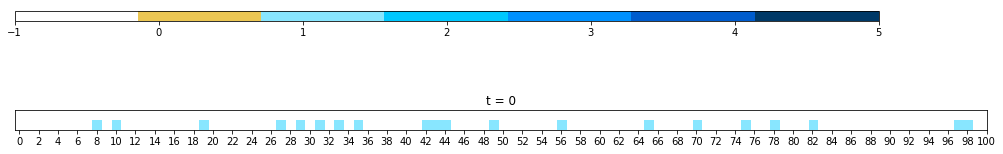

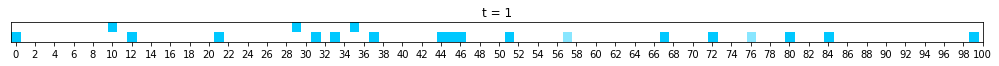

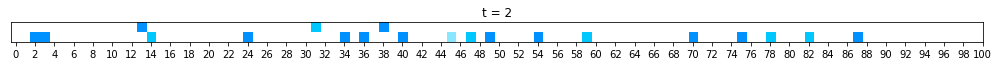

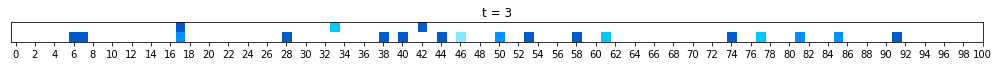

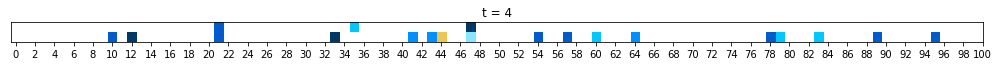

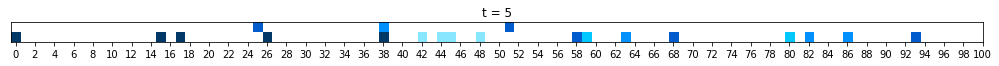

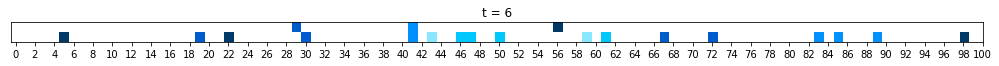

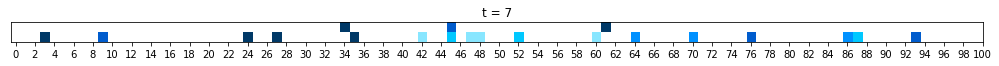

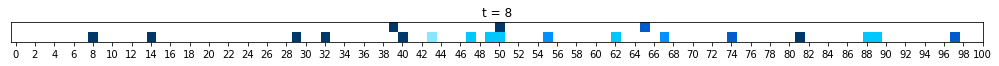

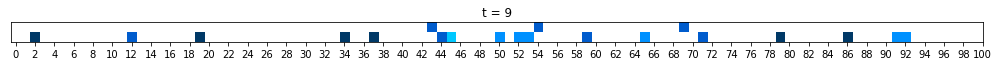

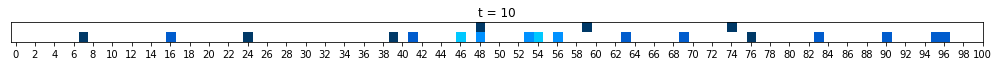

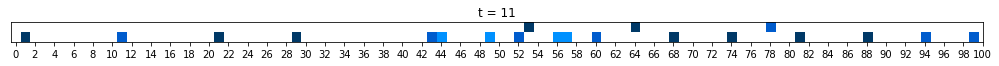

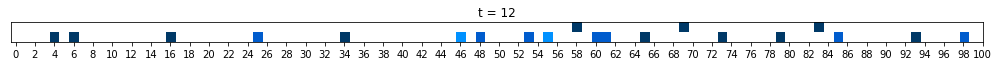

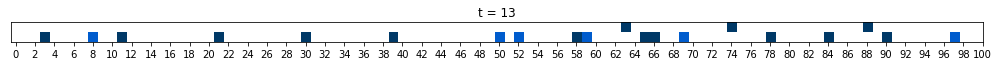

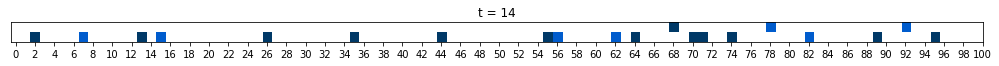

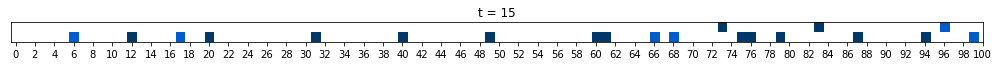

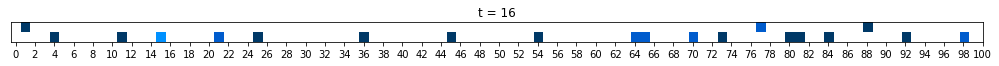

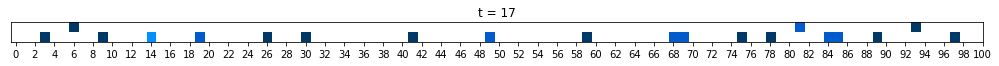

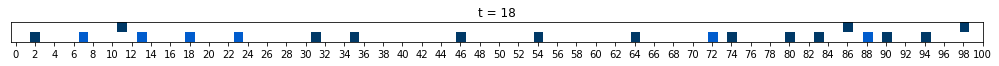

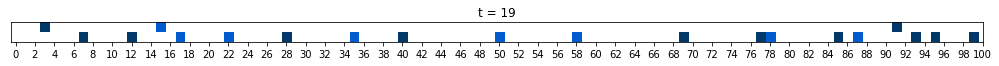

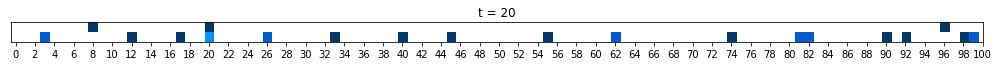

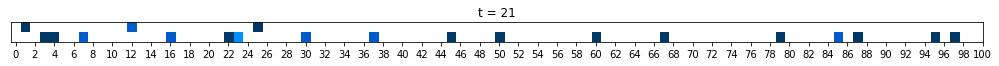

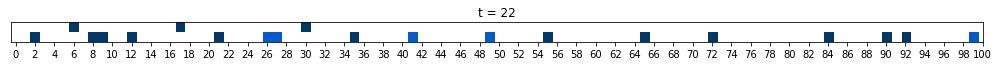

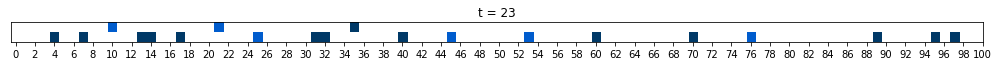

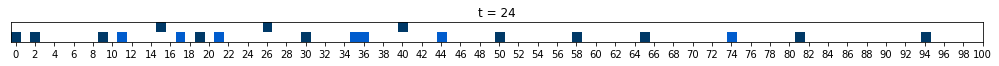

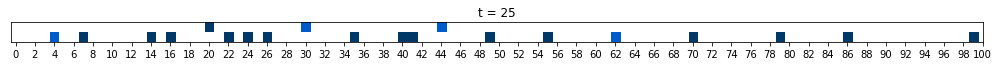

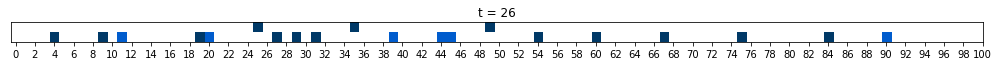

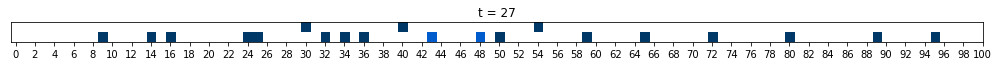

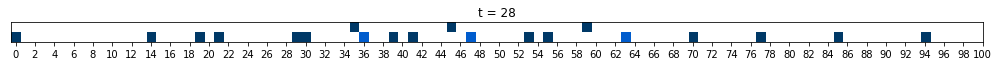

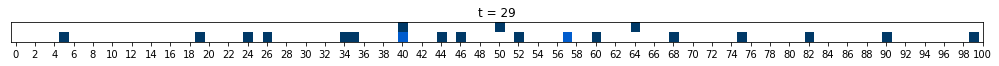

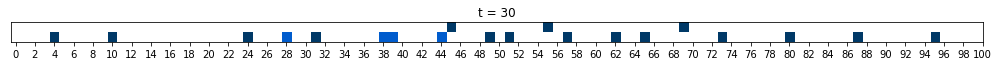

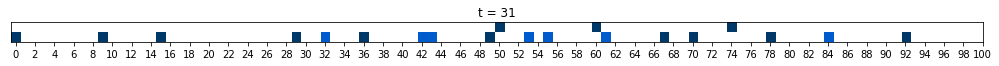

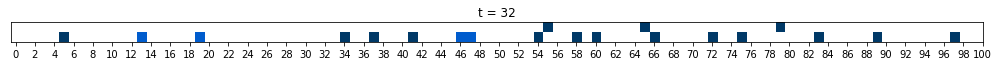

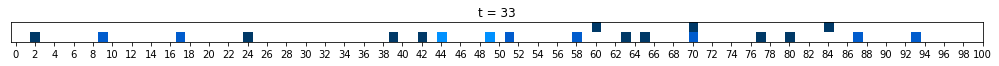

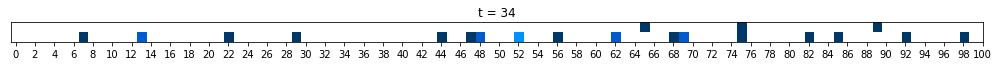

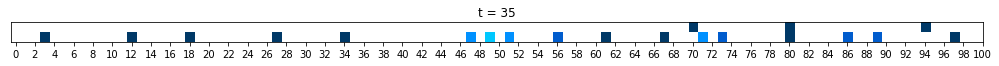

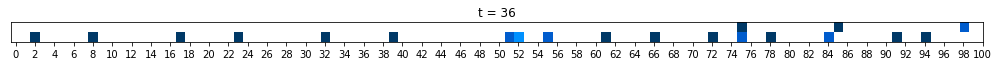

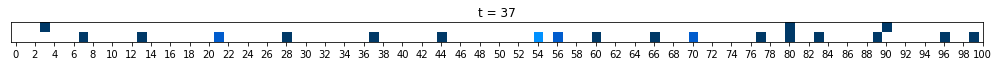

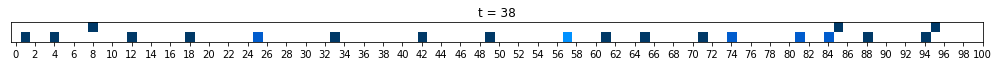

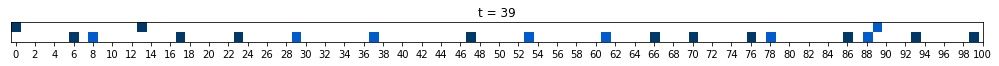

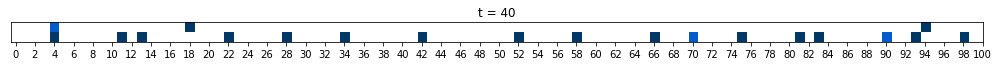

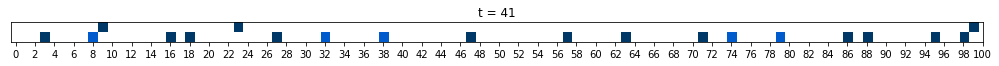

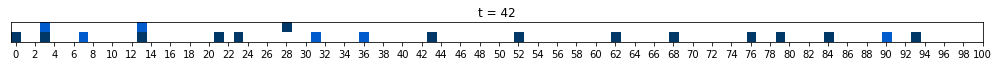

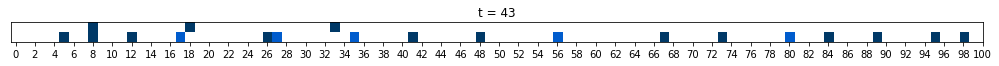

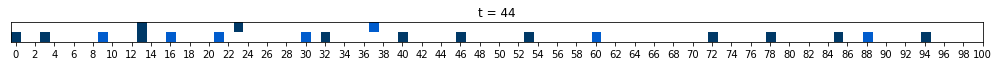

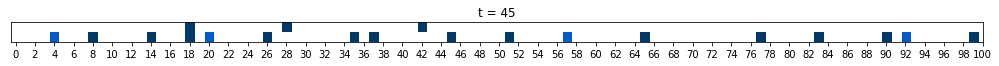

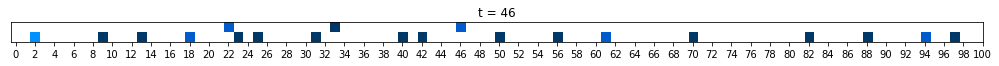

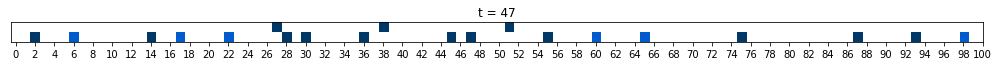

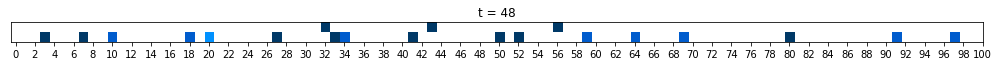

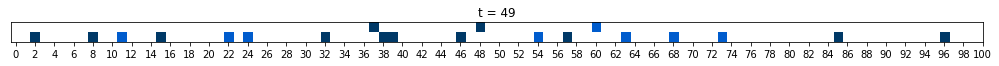

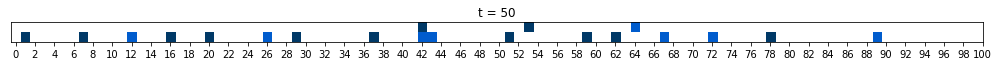

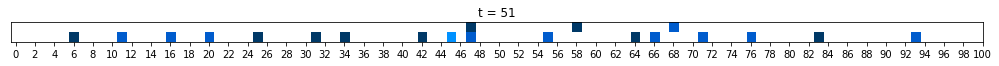

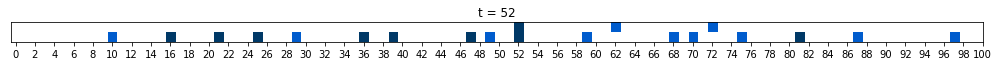

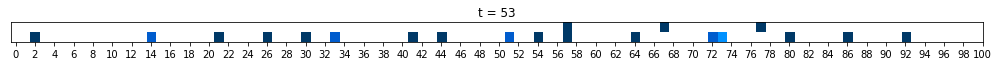

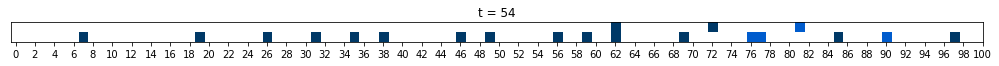

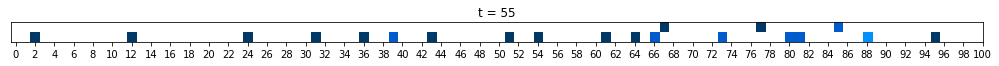

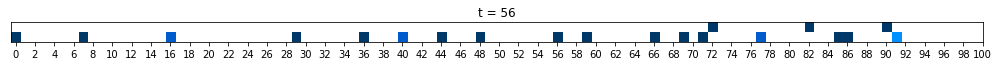

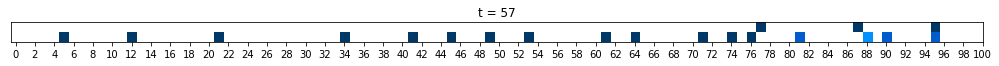

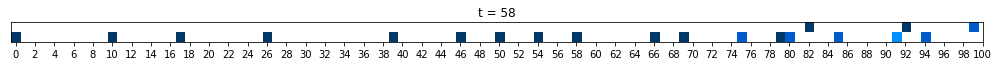

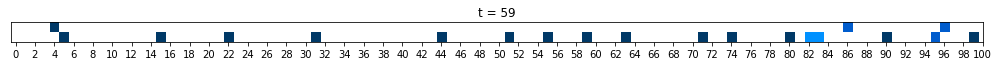

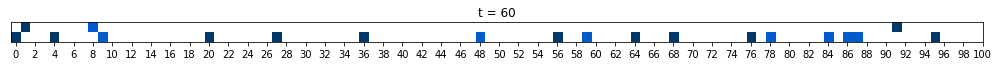

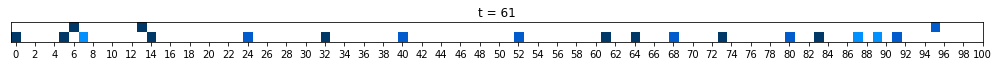

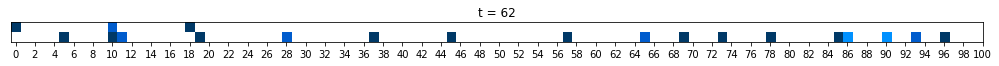

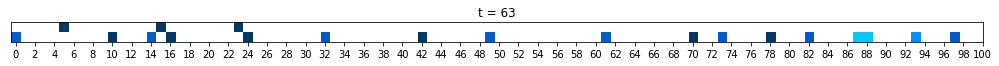

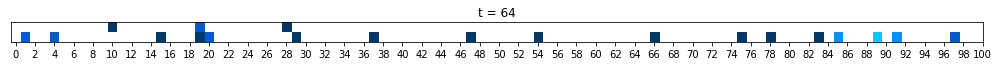

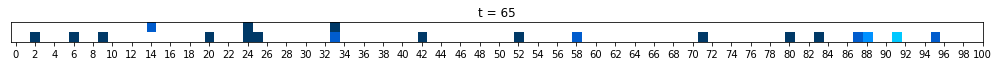

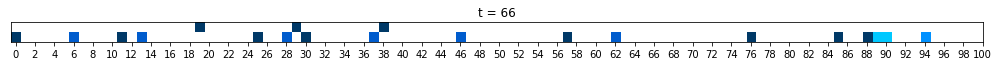

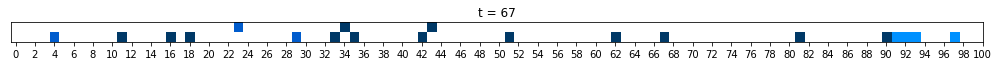

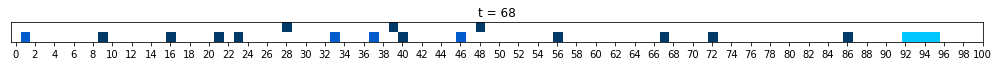

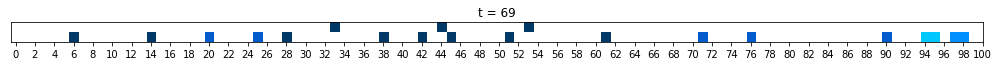

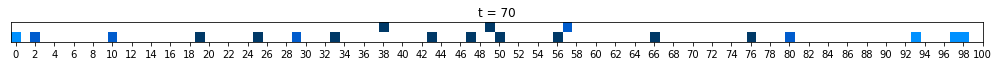

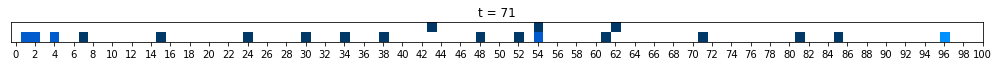

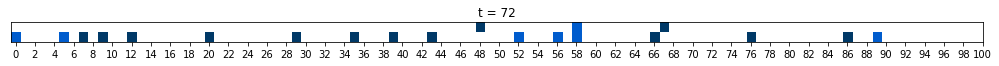

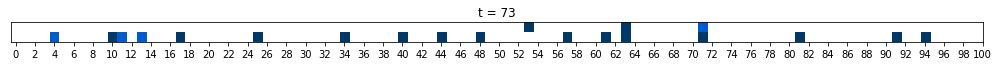

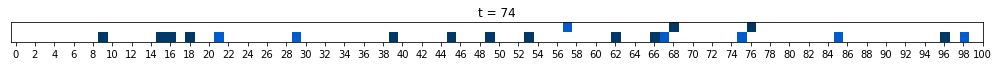

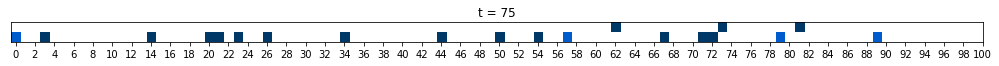

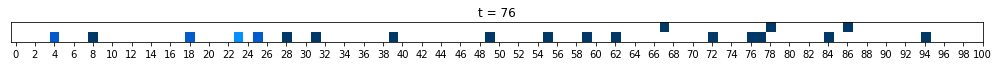

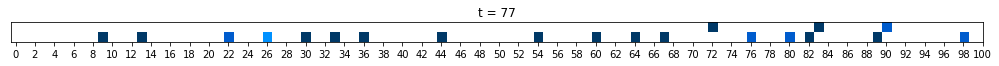

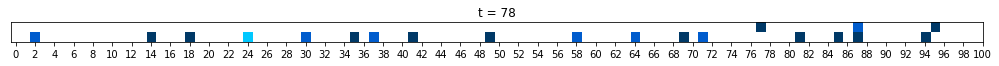

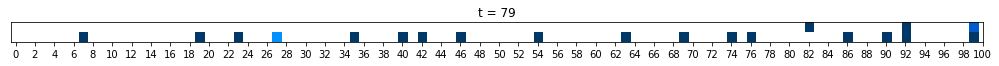

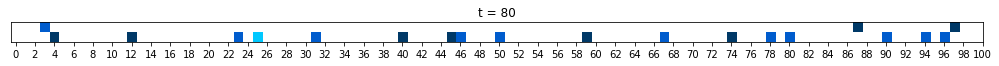

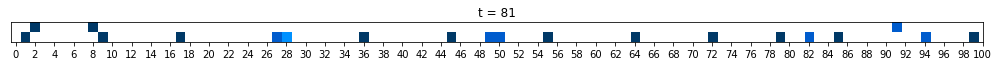

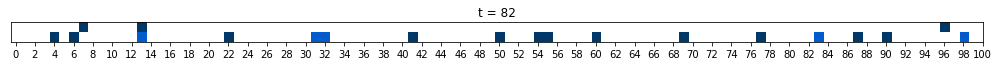

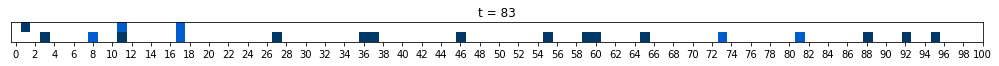

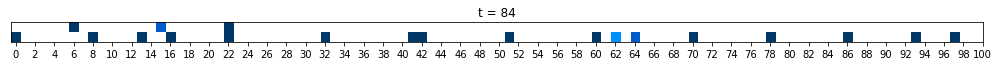

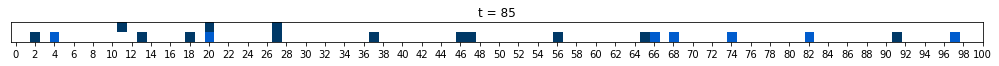

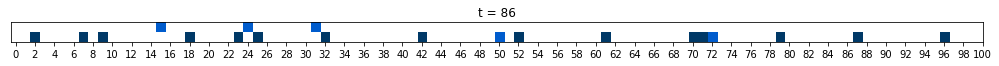

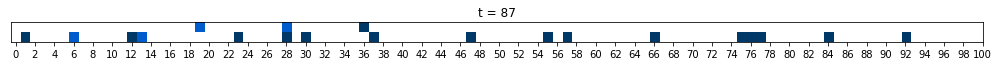

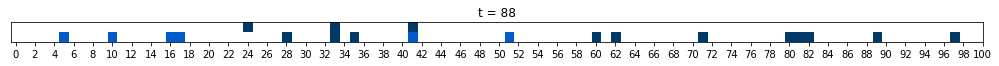

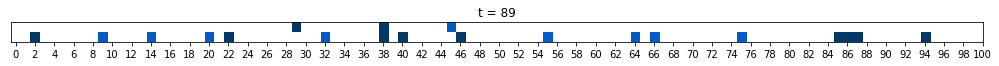

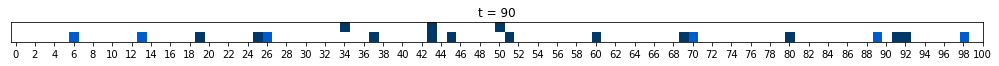

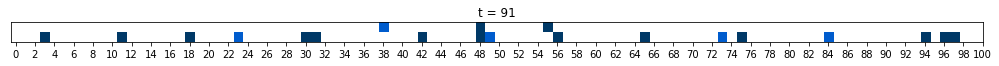

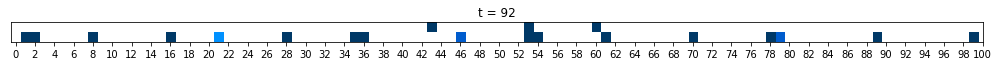

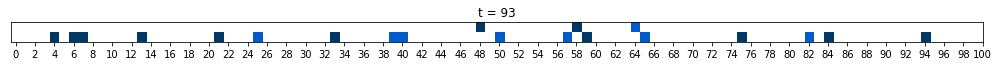

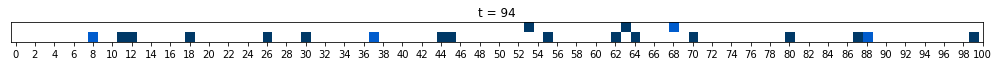

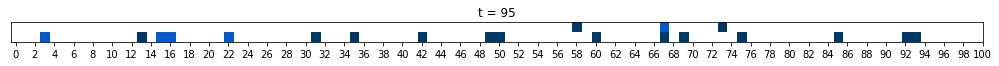

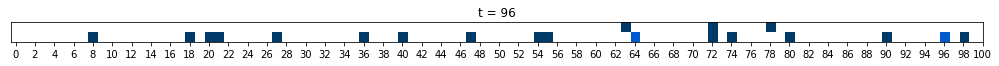

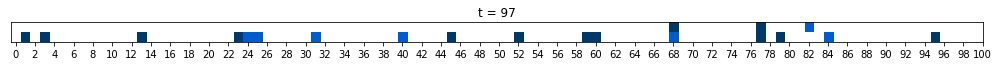

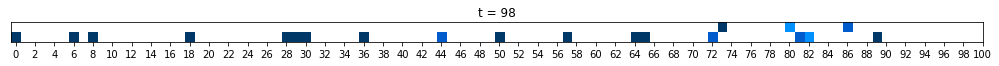

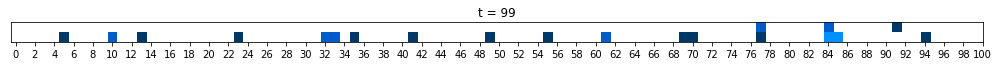

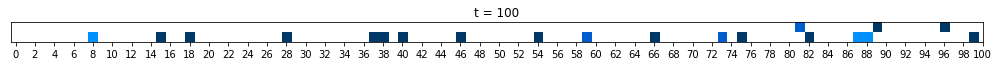

In [459]:
sim = TrafficSimulation(road_size = 100,density = 0.2)
sim.draw()

for _ in range(100):
    sim.update_simulation()
    sim.draw()
    

In [265]:
print(-1*np.ones((2,100)).shape)
print((-1*np.ones((2,100))).shape)


print(sim.road.shape)

()
(2, 100)
(100,)


In [218]:
np.arra

array([[-1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1.]])

In [452]:
(np.array([1,2]) + np.array([2,4])) % (3,1)

array([0, 0])

In [298]:
list(map(lambda x : x.id,list(filter(lambda x : x.lane == 1, cars))))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [281]:
[x.lane for x in cars]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [414]:
example_list = np.array([0,70])
#print(*example_list)
sim.road[tuple(example_list)]
#(np.array([1,2]) + np.array([2,4])) % 4

-1.0

In [ ]:
# road_size = 100
# density = 0.4
# n_cars = round(road_size * density)

# road = -1*np.ones(road_size)

# initial_positions = np.random.choice(range(road_size),n_cars,replace=False)

# cars = [Car(id=i, position= initial_positions[i],vmax=5) for i in range(n_cars)]
# sorted_ids = np.array([car.id for car in sorted(cars, key = lambda x : x.position)])



# print(road)

# for t in range(4):
#     for car in cars:
#         car.update_panorama()
#         car.update_v()
#         car.update_position()

#         road[car.position] = car.v

#     print(road)




# # for i,j in enumerate(sorted_ids):
# #     cars[j].front_car = sorted_ids[(i+1) % n_cars]
# #     cars[j].back_car = sorted_ids[(i-1) % n_cars]


# #     if cars[cars[j].front_car].position > cars[j].position:
# #         cars[j].front_gap = cars[cars[j].front_car].position - cars[j].position - 1
# #     else:
# #         cars[j].front_gap = road_size + (cars[cars[j].front_car].position - cars[j].position) - 1
    

# #     road[cars[j].position] = cars[j].v
    
# # print(road)
    